# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

print(os.getcwd())

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


c:\Users\user\Documents\research\BMCA-pipeline\notebooks\topologyB\all_data


In [2]:
os.chdir('../../..')
from src import BMCA, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyB/all_data/')

# Perturbing enzymes

In [4]:
ant ='../../../data/interim/Antimony/JSexample22.ant'  

data_file1 = '../../../data/interim/generated_data/JSexample22-noReg/JSexample22_1.01.csv'
data_file15 = '../../../data/interim/generated_data/JSexample22-noReg/JSexample22_1.5.csv'
data_file3 = '../../../data/interim/generated_data/JSexample22-noReg/JSexample22_3.csv'
data_file5 = '../../../data/interim/generated_data/JSexample22-noReg/JSexample22_5.csv'
data_file7 = '../../../data/interim/generated_data/JSexample22-noReg/JSexample22_7.csv'
data_file10 = '../../../data/interim/generated_data/JSexample22-noReg/JSexample22_10.csv'

r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

# data_files = [data_file05, data_file10, data_file15, data_file3, data_file5, data_file7, data_file100]

1.7241056990445864e-15

In [5]:
BMCA_obj1 = BMCA.BMCA(ant, data_file1)
BMCA_obj15 = BMCA.BMCA(ant, data_file15)
BMCA_obj3 = BMCA.BMCA(ant, data_file3)
BMCA_obj5 = BMCA.BMCA(ant, data_file5)
BMCA_obj7 = BMCA.BMCA(ant, data_file7)
BMCA_obj10 = BMCA.BMCA(ant, data_file10)


Model does not contain SBML fbc package information.


../../../data/interim/Antimony/JSexample22_cobra.ant
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v2>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v2>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v3>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v3>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v13>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v13>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v4>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v4>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v5>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v5>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v6>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v6>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v7>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v7

../../../data/interim/Antimony/JSexample22_cobra.ant


Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v2>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v2>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v3>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v3>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v13>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v13>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v4>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v4>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v5>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v5>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v6>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v6>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v7>'
Missing upper f

../../../data/interim/Antimony/JSexample22_cobra.ant


Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v2>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v2>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v3>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v3>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v13>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v13>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v4>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v4>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v5>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v5>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v6>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v6>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v7>'
Missing upper f

../../../data/interim/Antimony/JSexample22_cobra.ant


Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v2>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v2>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v3>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v3>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v13>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v13>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v4>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v4>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v5>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v5>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v6>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v6>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v7>'
Missing upper f

../../../data/interim/Antimony/JSexample22_cobra.ant


Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v2>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v2>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v3>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v3>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v13>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v13>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v4>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v4>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v5>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v5>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v6>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction v6>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction v7>'
Missing upper f

../../../data/interim/Antimony/JSexample22_cobra.ant


In [6]:
def run_ADVI(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,799.8


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,968.8


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,768.1


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 4,697.3


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 7,766.5


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 14,594


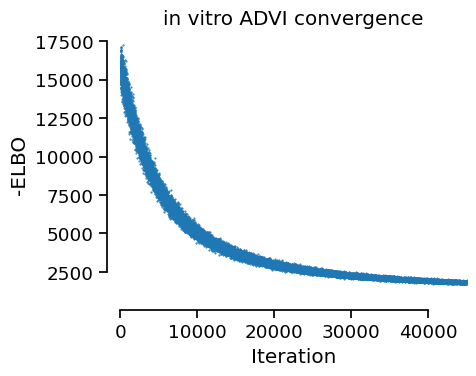

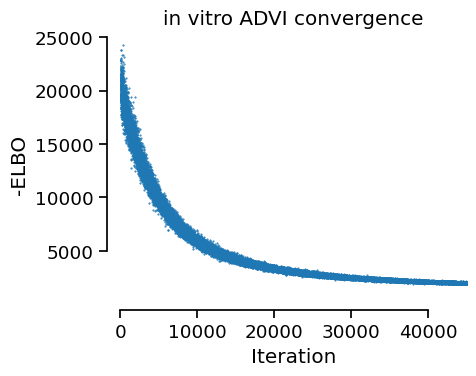

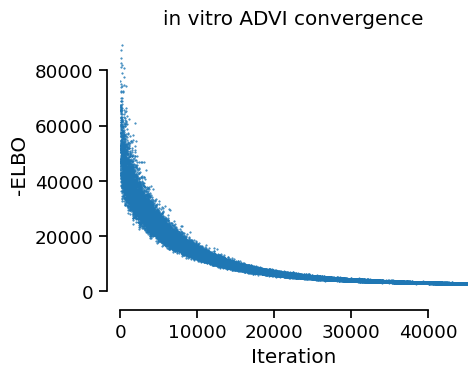

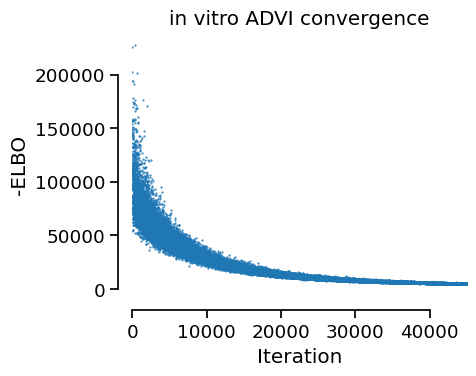

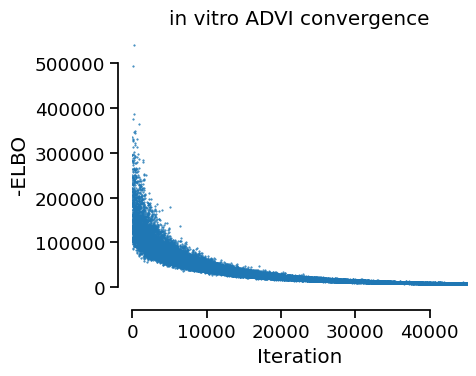

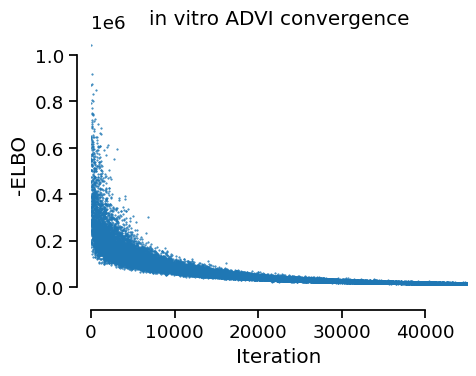

In [7]:
trace1 = run_ADVI(BMCA_obj1)
trace15 = run_ADVI(BMCA_obj15)
trace3 = run_ADVI(BMCA_obj3)
trace5 = run_ADVI(BMCA_obj5)
trace7 = run_ADVI(BMCA_obj7)
trace10 = run_ADVI(BMCA_obj10)

In [8]:
ExTrace_1 = (trace1['posterior']['Ex']).to_numpy().squeeze()
ExTrace_15 = (trace15['posterior']['Ex']).to_numpy().squeeze()
ExTrace_3 = (trace3['posterior']['Ex']).to_numpy().squeeze()
ExTrace_5 = (trace5['posterior']['Ex']).to_numpy().squeeze()
ExTrace_7 = (trace7['posterior']['Ex']).to_numpy().squeeze()
ExTrace_10 = (trace10['posterior']['Ex']).to_numpy().squeeze()

In [9]:
medEx_1 = np.median(ExTrace_1, axis=0)
medEx_15 = np.median(ExTrace_15, axis=0)
medEx_3 = np.median(ExTrace_3, axis=0)
medEx_5 = np.median(ExTrace_5, axis=0)
medEx_7 = np.median(ExTrace_7, axis=0)
medEx_10 = np.median(ExTrace_10, axis=0)

## Elasticity comparisons

In [10]:
r.getScaledElasticityMatrix()

               D,         B,         O,        F,        H,        M,        E,         R,        I,         C,       N,         G,         L
v2  [[         0, -0.278258,         0,        0,        0,        0,        0,         0,        0,         0,       0,         0,         0],
v3   [         0,  0.935606,         0,        0,        0,        0,        0, -0.802015,        0,         0,       0,         0,         0],
v13  [         0,         0,         0,        0,        0,        0,        0, 0.0623672,        0,         0,       0,         0,         0],
v4   [         0,  0.796355,         0,        0,        0,        0,        0,         0,        0, -0.713758,       0,         0,         0],
v5   [ -0.871102,         0,         0,        0,        0,        0,        0,         0,        0,  0.946124,       0,         0,         0],
v6   [   3.12742,         0,         0,        0,        0,        0, -3.09262,         0,        0,         0,       0,         0,       

In [11]:
# first regulator, H on v5
a = [pd.DataFrame(r.getScaledElasticityMatrix(), columns=r.getFloatingSpeciesIds(), index=r.getReactionIds()).loc['v5']]
for i in [medEx_1, medEx_15, medEx_3, medEx_5, medEx_7, medEx_10]:
    aa = pd.DataFrame(i, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds()).loc['v5']
    a.append(aa)
a = pd.concat(a, axis=1)
a.set_axis(['gt', '1.01x', '1.5x', '3x', '5x', '7x', '10x'], axis='columns') 

,gt,1.01x,1.5x,3x,5x,7x,10x
D,-0.871102,-0.989712,-0.810864,-0.836114,-0.830519,-0.815897,-0.893954
B,0.000000,-0.008191,0.004079,-0.002158,-0.008521,-0.002715,0.000222
O,0.000000,0.002572,-0.001793,0.000480,-0.013565,0.007463,-0.011842
F,0.000000,-0.003082,-0.002351,-0.004196,-0.004621,-0.000466,0.022537
H,0.000000,0.002831,-0.001288,-0.003661,-0.002545,-0.003892,0.011709
M,0.000000,-0.003992,0.001353,0.001533,-0.000618,0.004221,-0.017745
E,0.000000,0.004025,-0.000273,0.006646,0.010801,0.018449,0.062754
R,0.000000,0.002812,0.001507,-0.001974,-0.002407,-0.000281,0.006526
I,0.000000,0.009020,0.004914,0.003034,0.004340,-0.000319,-0.008962
C,0.946124,0.714941,0.882001,0.955343,0.968780,0.979059,0.973946


In [12]:
# second regulator, O on v15
a = [pd.DataFrame(r.getScaledElasticityMatrix(), columns=r.getFloatingSpeciesIds(), index=r.getReactionIds()).loc['v15']]
for i in [medEx_1, medEx_15, medEx_3, medEx_5, medEx_7, medEx_10]:
    aa = pd.DataFrame(i, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds()).loc['v15']
    a.append(aa)
a = pd.concat(a, axis=1)
a.set_axis(['gt', '1.01x', '1.5x', '3x', '5x', '7x', '10x'], axis='columns') 

,gt,1.01x,1.5x,3x,5x,7x,10x
D,0.000000,-0.005083,0.004919,-0.005941,-0.002506,-0.000835,-0.004306
B,0.000000,-0.007805,-0.006781,0.004745,0.010568,0.015261,0.017181
O,0.000000,0.002974,0.002567,0.001243,-0.007211,-0.010137,0.015636
F,0.680862,0.870832,0.693709,0.614085,0.573548,0.538093,0.537589
H,0.000000,0.004506,0.003452,-0.012885,-0.005037,0.000620,-0.014025
M,0.000000,-0.006288,0.003553,-0.002420,0.001412,-0.003987,0.001352
E,0.000000,-0.005596,0.004171,-0.003102,-0.005304,-0.023916,-0.043460
R,0.000000,0.004763,0.004600,0.008726,0.005195,0.002455,0.008487
I,0.000000,0.005099,0.005435,0.000907,0.002902,0.010609,0.002383
C,0.000000,0.013062,-0.004050,0.008204,0.008176,0.028664,0.033465


## Calculating FCCs

In [13]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [14]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(1000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(1000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    # return CCC.eval(), FCC
    return FCC


### Negative predictions

In [15]:
postFCC1 = estimate_CCs(BMCA_obj1, ExTrace_1)
postFCC15 = estimate_CCs(BMCA_obj15, ExTrace_15)
postFCC3 = estimate_CCs(BMCA_obj3, ExTrace_3)
postFCC5 = estimate_CCs(BMCA_obj5, ExTrace_5)
postFCC7 = estimate_CCs(BMCA_obj7, ExTrace_7)
postFCC10 = estimate_CCs(BMCA_obj10, ExTrace_10)

In [16]:
rxn_FCCs = [postFCC1, postFCC15, postFCC3, postFCC5, postFCC7, postFCC10]
pt_labels = ['1.01x', '1.5x', '3x', '5x', '7x', '10x']

In [17]:
def append_FCC_df(postFCC, label):
    dfs=[]
    
    for idx, rxn in enumerate(r.getReactionIds()):
        # negativity applied here
        df = -pd.DataFrame(postFCC[:,idx,:], columns=r.getReactionIds())
        df['pt_rxn']=[rxn]*len(df)
        dfs.append(df)
    
    w = pd.concat(dfs)
    w['pt_str']=[label]*len(w)
    return w

prd_FCCs = pd.concat([append_FCC_df(rxn_FCCs[i], pt_labels[i]) for i in range(len(rxn_FCCs))])

In [18]:
medPrdFCCs = pd.pivot_table(prd_FCCs, index=['pt_rxn','pt_str'], aggfunc='median', sort=False)
medPrdFCCs.head()

,,v2,v3,v13,v4,v5,v6,v7,v8,v9,v10,v11,v12,v14,v15,v16,v17,v18,v19,v21
pt_rxn,pt_str,,,,,,,,,,,,,,,,,,,
v2,1.01x,-1.844271,0.116659,0.065980,0.070326,0.113051,0.086280,0.098412,0.008675,0.044094,0.025998,0.029532,0.021283,0.002948,0.001462,0.001298,0.000895,0.000454,-0.001227,0.000309
v3,1.01x,0.256838,-1.420746,0.340573,-0.023470,-0.038728,-0.031345,-0.033102,-0.005538,-0.012782,-0.011499,-0.007697,-0.013932,-0.000407,0.000154,0.003888,-0.000283,-0.001645,-0.003453,0.000869
v13,1.01x,0.256838,0.579254,-1.659427,-0.023470,-0.038728,-0.031345,-0.033102,-0.005538,-0.012782,-0.011499,-0.007697,-0.013932,-0.000407,0.000154,0.003888,-0.000283,-0.001645,-0.003453,0.000869
v4,1.01x,0.097612,-0.015651,-0.008988,-1.896481,0.157036,0.125650,0.142919,0.012058,0.065606,0.036768,0.040299,0.031525,0.004299,0.003192,0.001132,-0.000357,0.000246,-0.000232,0.000059
v5,1.01x,0.097612,-0.015651,-0.008988,0.103519,-1.842964,0.125650,0.142919,0.012058,0.065606,0.036768,0.040299,0.031525,0.004299,0.003192,0.001132,-0.000357,0.000246,-0.000232,0.000059


### Graphing the averaged differences between ground truth and predicted distributions

C:\Users\user\AppData\Local\Temp\ipykernel_14464\3859003407.py:12: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



<Figure size 1600x1000 with 0 Axes>

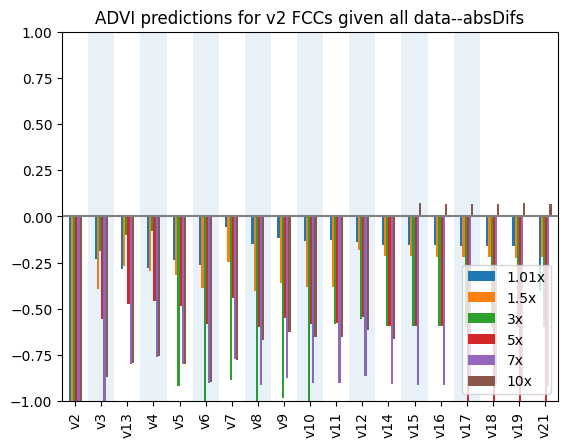

<Figure size 1600x1000 with 0 Axes>

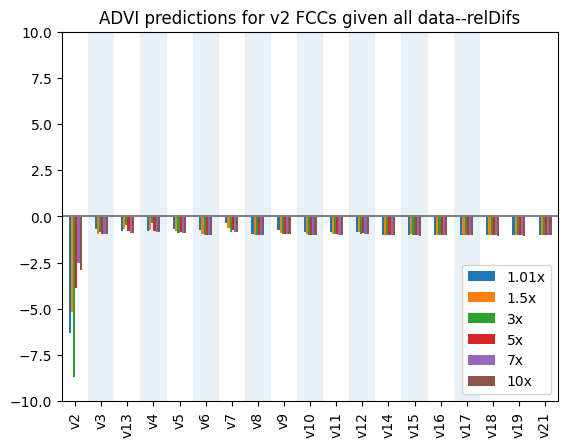

<Figure size 1600x1000 with 0 Axes>

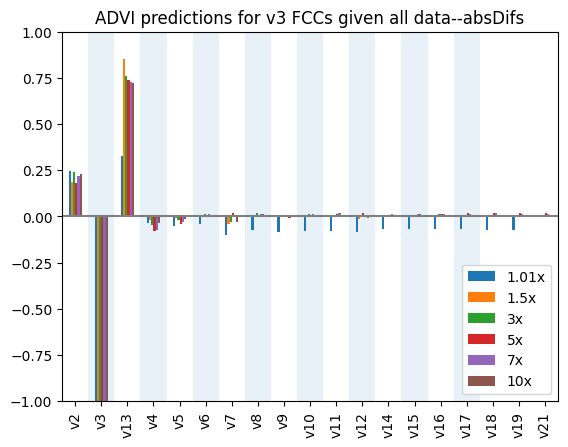

<Figure size 1600x1000 with 0 Axes>

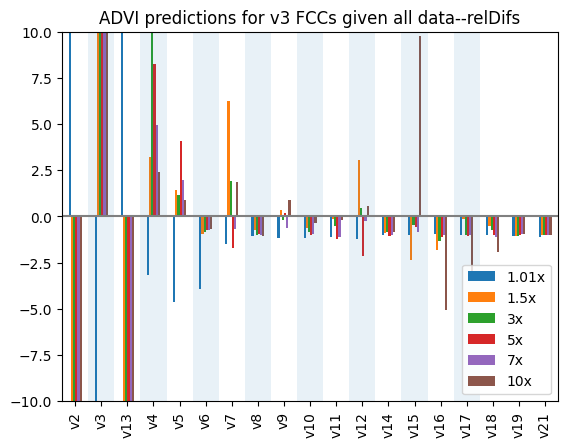

<Figure size 1600x1000 with 0 Axes>

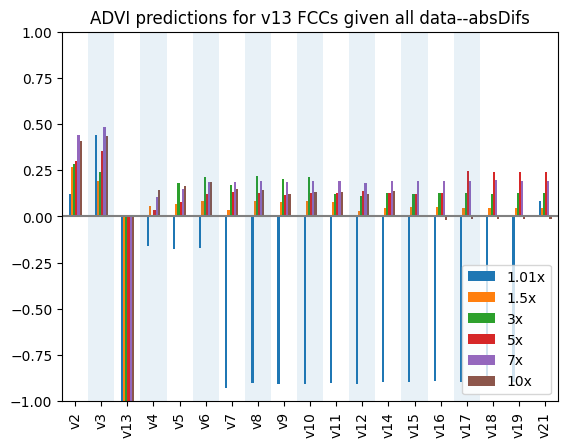

<Figure size 1600x1000 with 0 Axes>

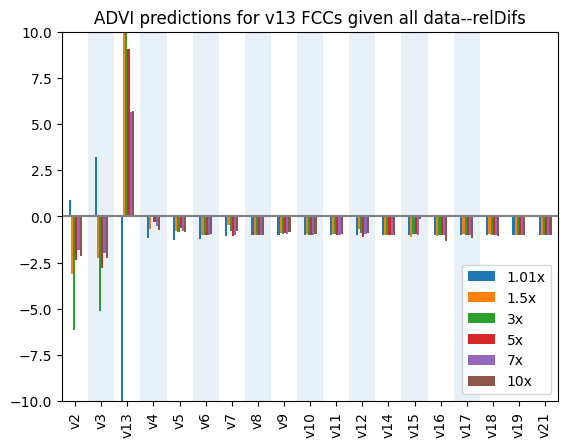

<Figure size 1600x1000 with 0 Axes>

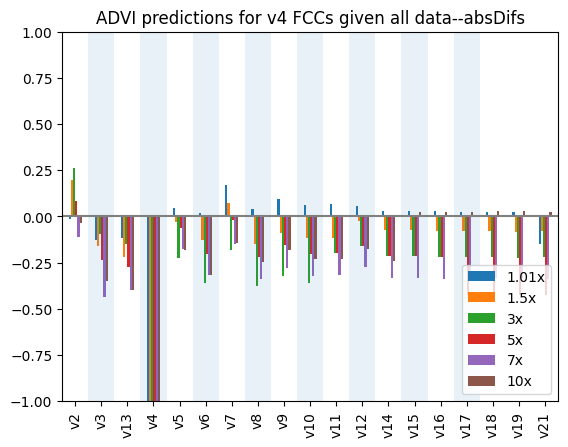

<Figure size 1600x1000 with 0 Axes>

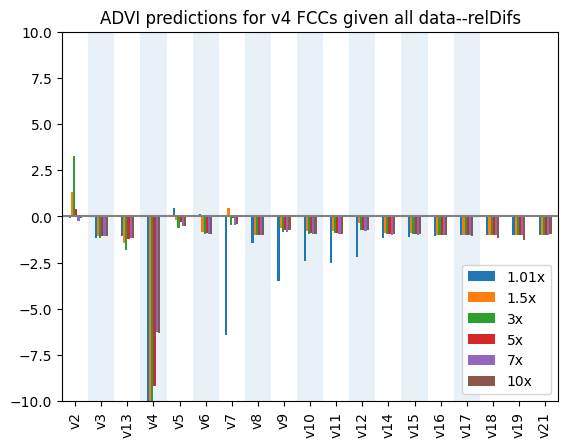

<Figure size 1600x1000 with 0 Axes>

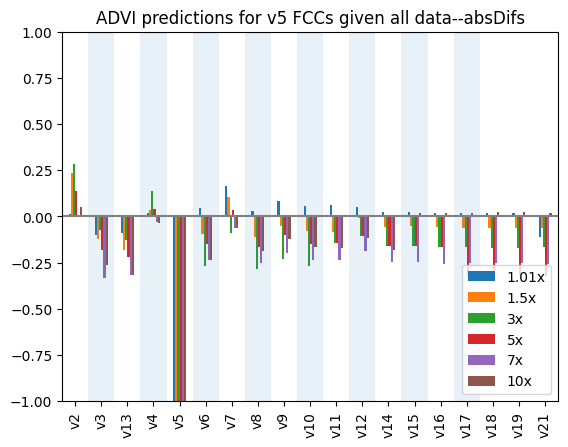

<Figure size 1600x1000 with 0 Axes>

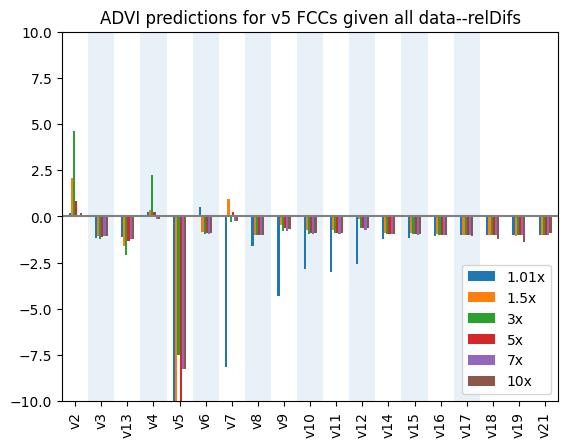

<Figure size 1600x1000 with 0 Axes>

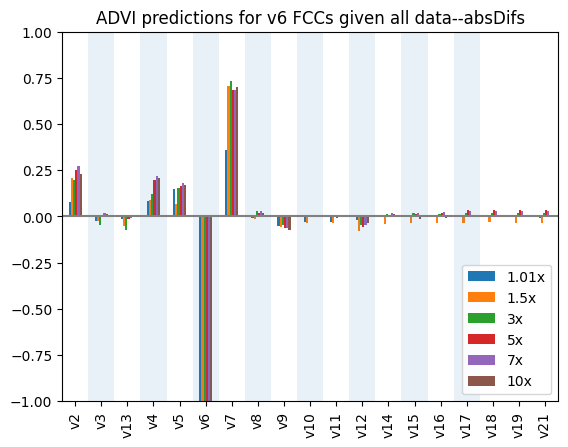

<Figure size 1600x1000 with 0 Axes>

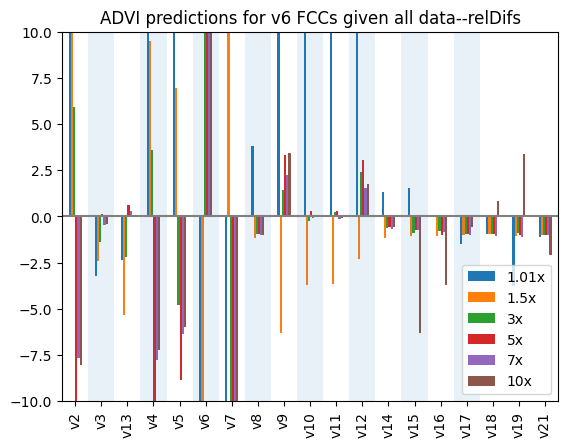

<Figure size 1600x1000 with 0 Axes>

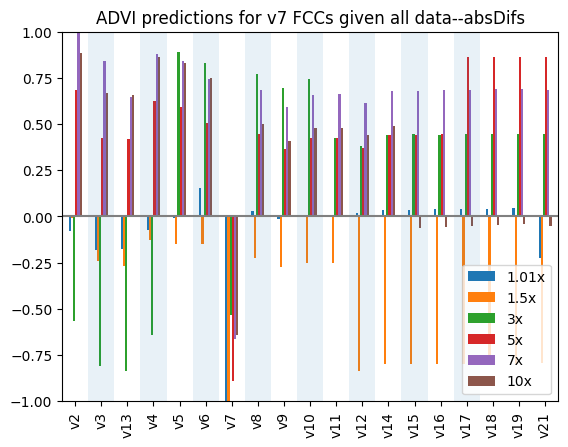

<Figure size 1600x1000 with 0 Axes>

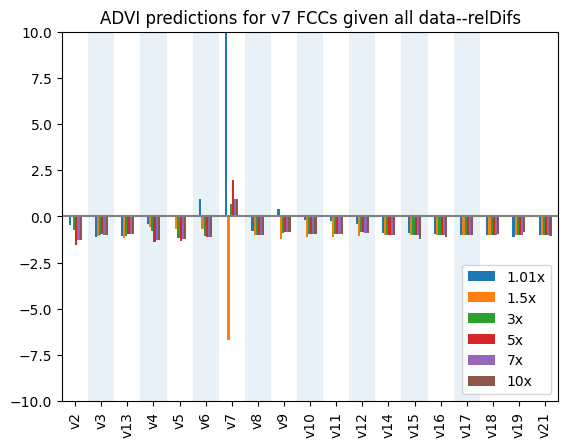

<Figure size 1600x1000 with 0 Axes>

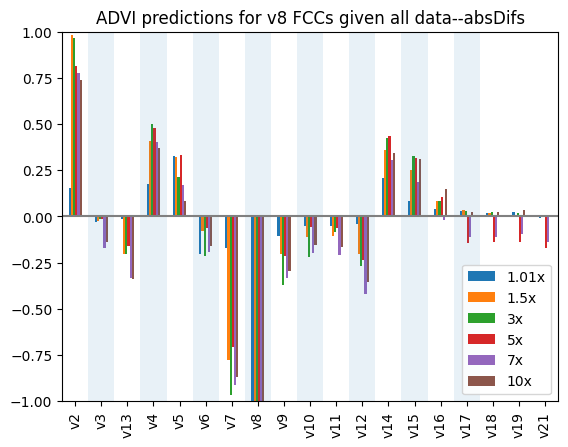

<Figure size 1600x1000 with 0 Axes>

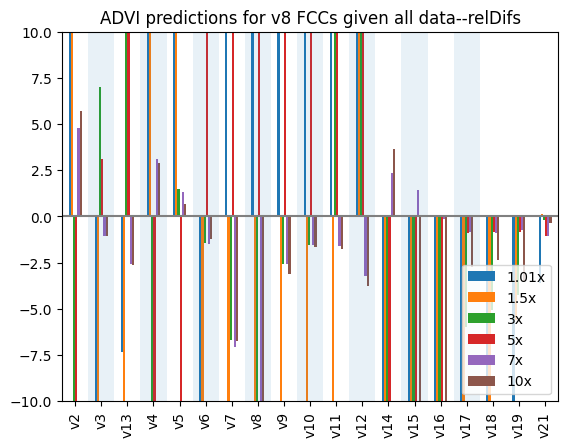

<Figure size 1600x1000 with 0 Axes>

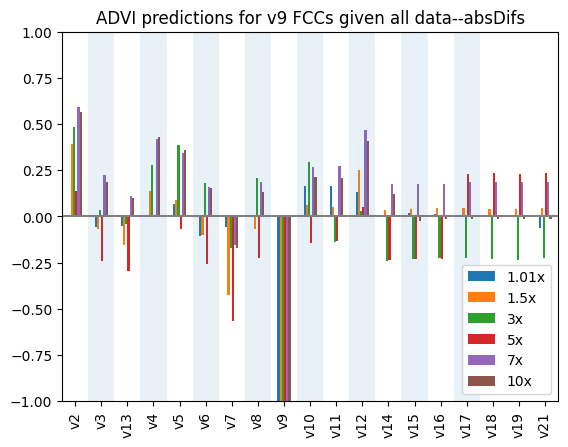

<Figure size 1600x1000 with 0 Axes>

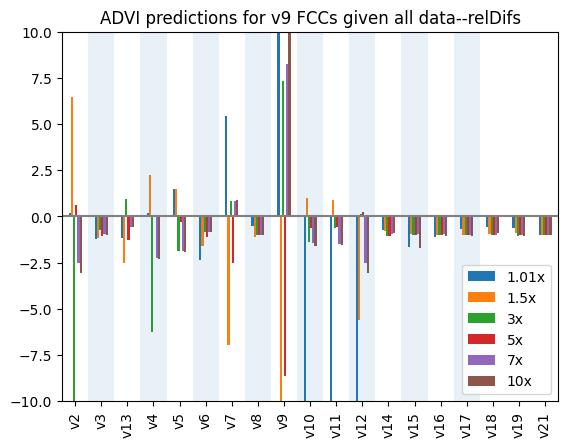

<Figure size 1600x1000 with 0 Axes>

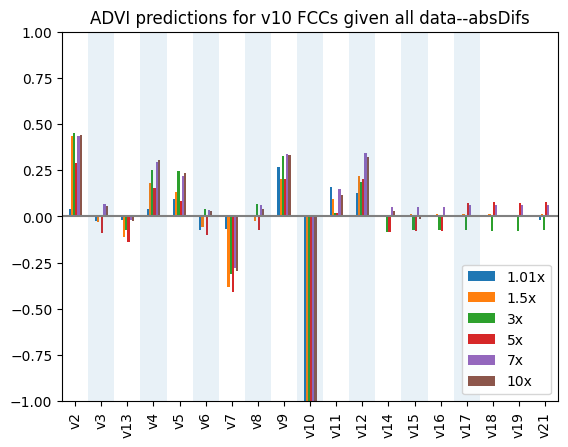

<Figure size 1600x1000 with 0 Axes>

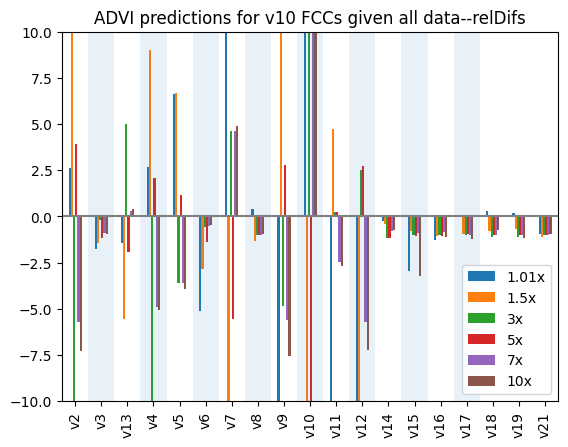

<Figure size 1600x1000 with 0 Axes>

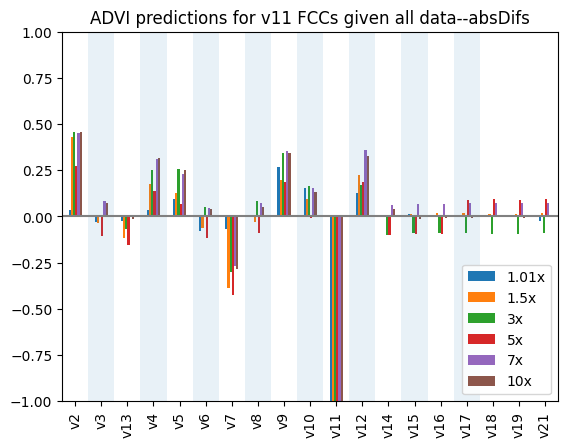

<Figure size 1600x1000 with 0 Axes>

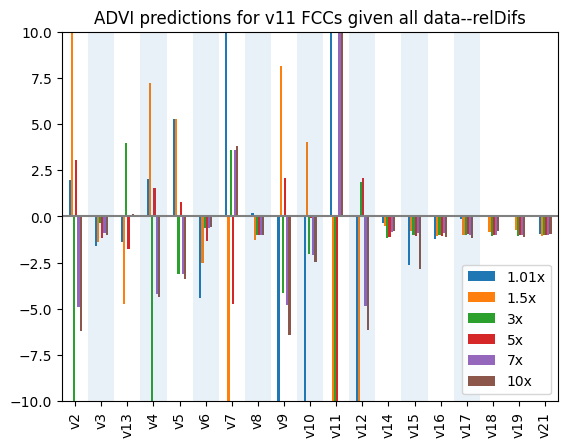

<Figure size 1600x1000 with 0 Axes>

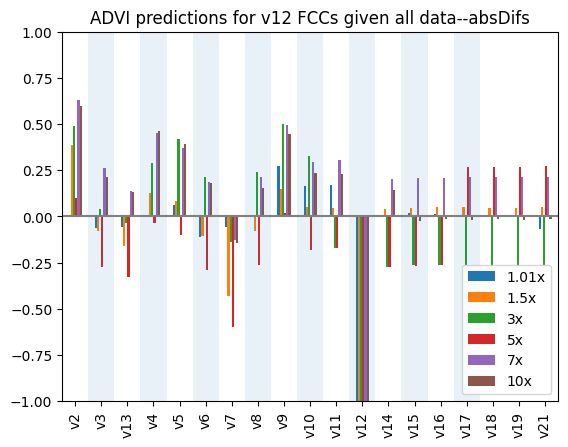

<Figure size 1600x1000 with 0 Axes>

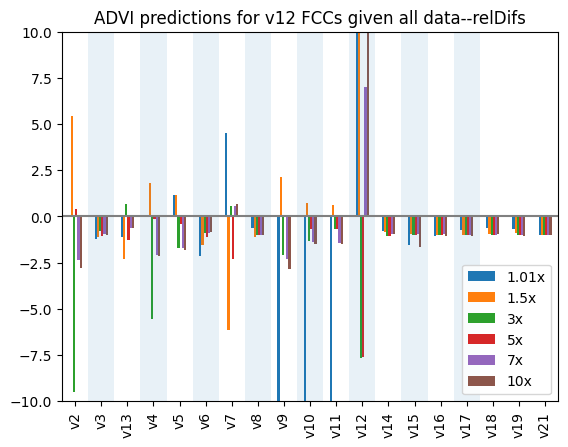

<Figure size 1600x1000 with 0 Axes>

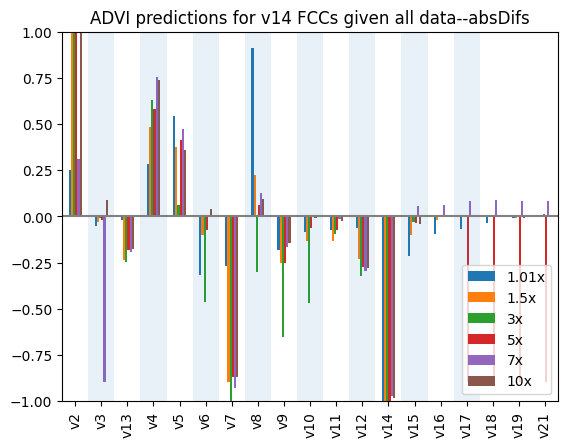

<Figure size 1600x1000 with 0 Axes>

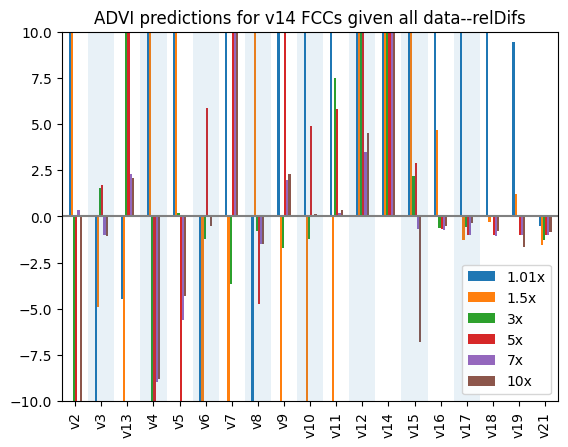

<Figure size 1600x1000 with 0 Axes>

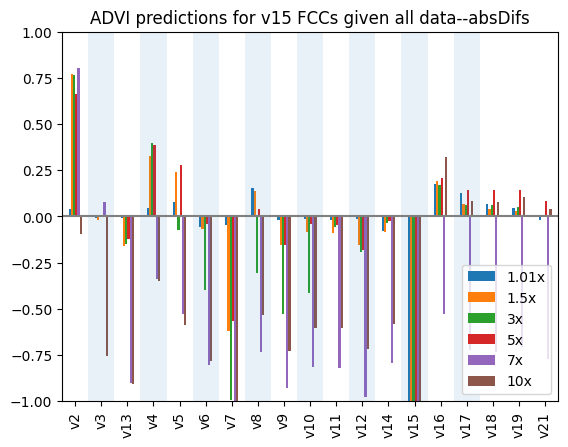

<Figure size 1600x1000 with 0 Axes>

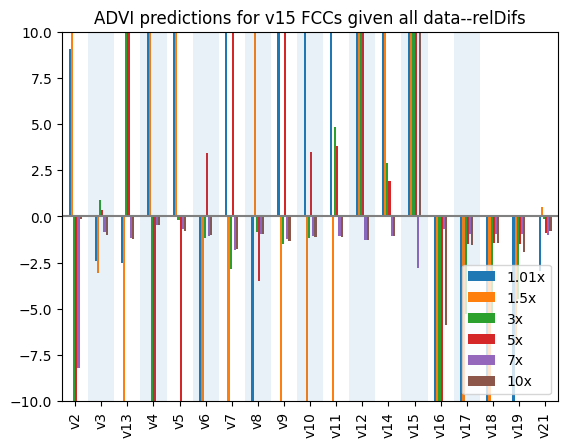

<Figure size 1600x1000 with 0 Axes>

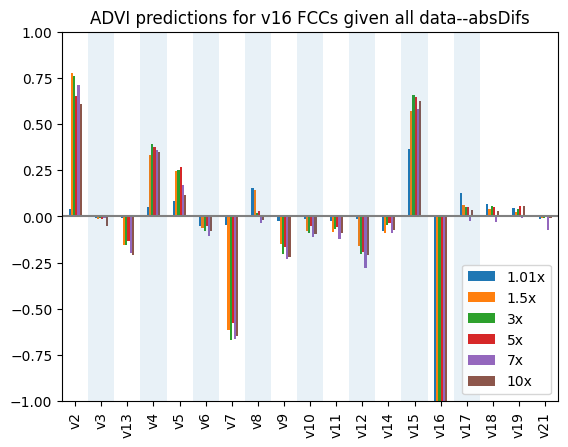

<Figure size 1600x1000 with 0 Axes>

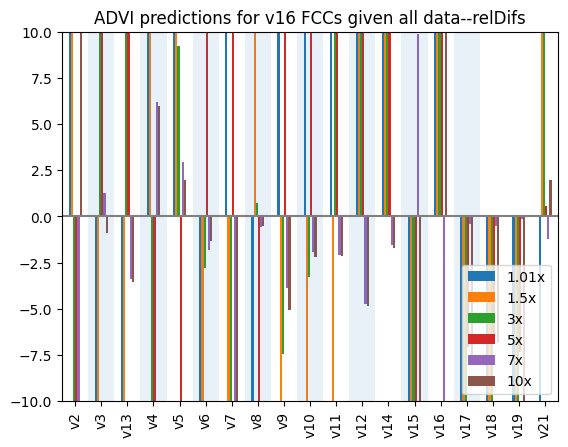

<Figure size 1600x1000 with 0 Axes>

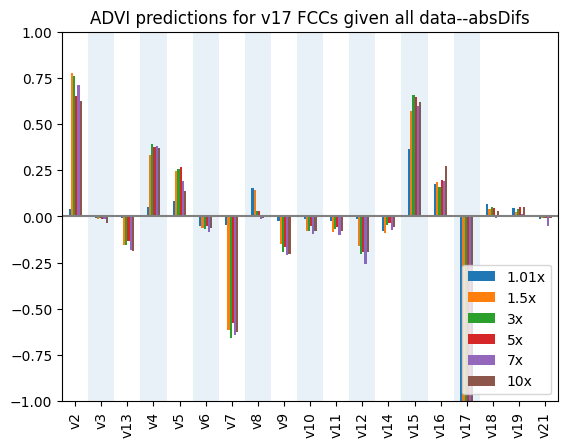

<Figure size 1600x1000 with 0 Axes>

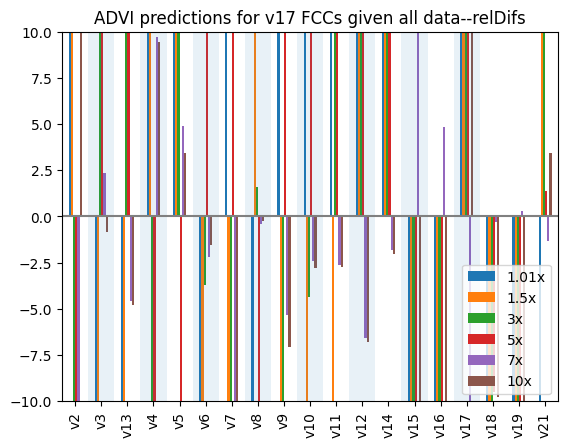

<Figure size 1600x1000 with 0 Axes>

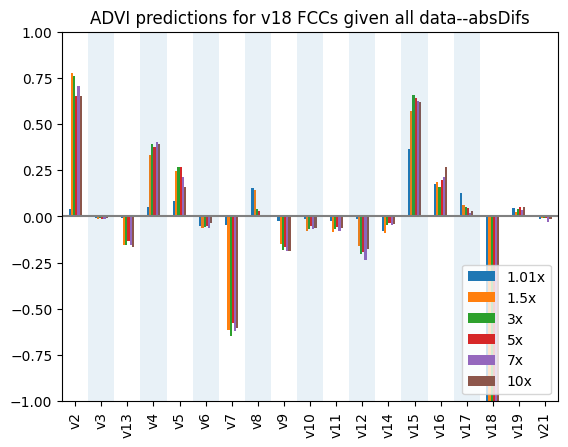

<Figure size 1600x1000 with 0 Axes>

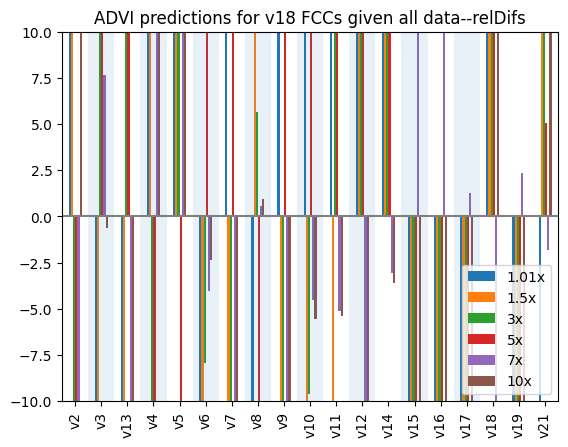

<Figure size 1600x1000 with 0 Axes>

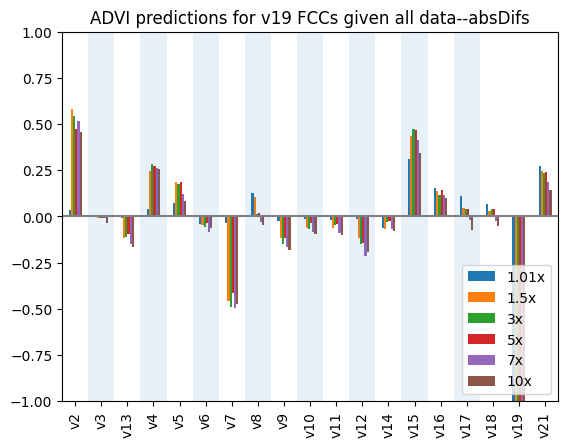

<Figure size 1600x1000 with 0 Axes>

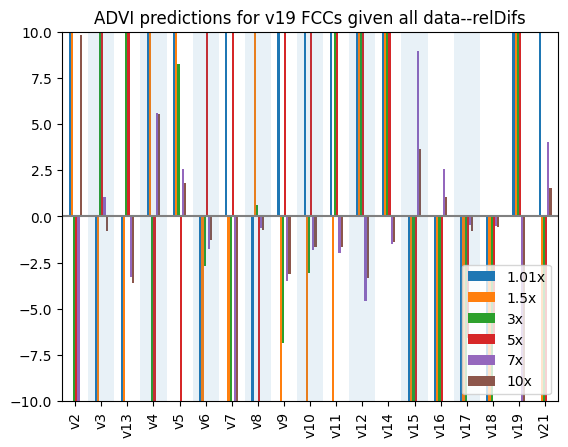

<Figure size 1600x1000 with 0 Axes>

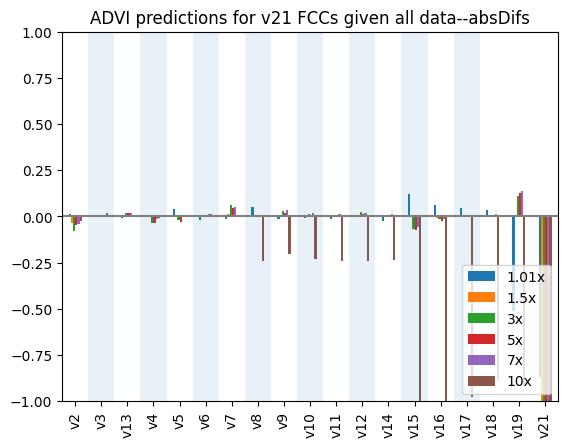

<Figure size 1600x1000 with 0 Axes>

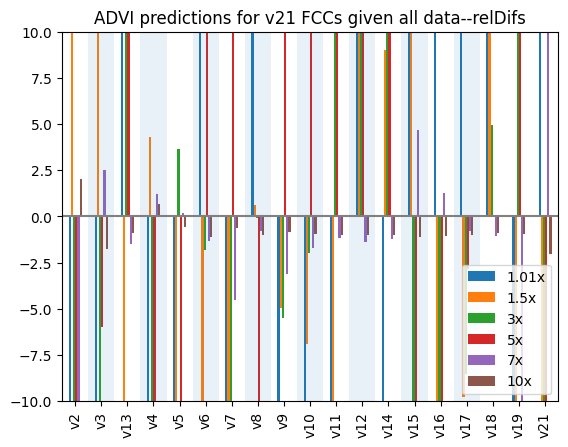

In [19]:
# for each reaction that can be perturbed
for rxn in r.getReactionIds():
    # locate the applicable rows in the medPrdFCCs df
    a = medPrdFCCs.loc[rxn]
    gtvals = np.repeat(gtFCC[rxn].values, repeats=len(pt_labels), axis=0).reshape((len(pt_labels), -1))
    # calculate the absolute difference...
    absDifs = a - gtvals
    # and the relative difference
    relDifs = absDifs/gtvals
    
    # plot both graphs 
    f1 = plt.figure(figsize=(16, 10))
    absDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-1,1))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--absDifs')

    f2 = plt.figure(figsize=(16, 10))
    relDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-10,10))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--relDifs')

In [20]:
plt.close("all")

## Evaluating FCC ranking

In [21]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')
# gtFCC_rankings

In [22]:
m1 = gtFCC_rankings.isin([1.0])  
m2 = gtFCC_rankings.isin([2.0])  
m3 = gtFCC_rankings.isin([3.0])  
a = m1.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
b = m2.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
c = m3.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)

trueRanks = pd.concat([a,b,c], axis=1)
trueRanks['topThree'] = trueRanks[0] + trueRanks[1] + trueRanks[2]

In [23]:
rxn_FCCs = [postFCC1, postFCC15, postFCC3, postFCC5, postFCC7, postFCC10]
scores = []
for pt_level in rxn_FCCs:
    postFCC_med=pd.DataFrame(np.median(pt_level, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
    # m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
    postFCC_med = pd.DataFrame(np.select([m1], [float('Nan')], postFCC_med), columns=gtFCC.columns, index=gtFCC.index)
    postFCC_med_rankings= postFCC_med.rank(axis=1, ascending=False, na_option='keep')
  
    m1 = postFCC_med_rankings.isin([1.0])  
    m2 = postFCC_med_rankings.isin([2.0])  
    m3 = postFCC_med_rankings.isin([3.0])  
    a = m1.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
    b = m2.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
    c = m3.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)

    prdRanks = pd.concat([a,b,c], axis=1)
    prdRanks['topThree'] = prdRanks[0] + prdRanks[1] + prdRanks[2]

    scores.append([len([i for i in prdRanks['topThree'][rxn] if i in trueRanks['topThree'][rxn]]) for rxn in r.getReactionIds()])

topThreeCheckdf = pd.DataFrame(scores, columns=r.getReactionIds(), index=pt_labels).T

In [24]:
topThreeCheckdf.style.background_gradient(cmap='RdYlBu', axis=None)
# sns.heatmap(topThreeCheckdf, annot=True, cmap='RdYlBu')

,1.01x,1.5x,3x,5x,7x,10x
v2,0,3,2,3,2,3
v3,1,3,1,2,1,2
v13,1,3,1,2,1,2
v4,2,3,2,3,2,3
v5,1,3,2,3,2,3
v6,1,3,2,3,2,3
v7,1,3,2,3,2,3
v8,1,2,1,2,1,2
v9,0,3,2,3,2,3
v10,0,2,1,2,2,2


In [25]:
topThreeCheckdf.sum(axis=0)

1.01x    14
1.5x     52
3x       33
5x       51
7x       34
10x      51
dtype: int64

In [26]:
for i in r.getReactionIds():
    a = gtFCC_rankings.loc[i].values
    b = postFCC_med_rankings.loc[i].values
    spcorr = stats.spearmanr(a,b,nan_policy='omit')
    print(i, spcorr)

v2 SpearmanrResult(correlation=0.9071207430340558, pvalue=2.0736991664353693e-07)
v3 SpearmanrResult(correlation=0.9360165118679049, pvalue=1.1541884991436047e-08)
v13 SpearmanrResult(correlation=0.9339525283797729, pvalue=1.478148230861387e-08)
v4 SpearmanrResult(correlation=0.8844169246646028, pvalue=1.107920999077685e-06)
v5 SpearmanrResult(correlation=0.8823529411764706, pvalue=1.2678715297879366e-06)
v6 SpearmanrResult(correlation=0.9339525283797729, pvalue=1.478148230861387e-08)
v7 SpearmanrResult(correlation=0.9236326109391124, pvalue=4.568456687421577e-08)
v8 SpearmanrResult(correlation=0.9814241486068112, pvalue=6.725639702470185e-13)
v9 SpearmanrResult(correlation=0.977296181630547, pvalue=3.3060534468874615e-12)
v10 SpearmanrResult(correlation=0.977296181630547, pvalue=3.3060534468874615e-12)
v11 SpearmanrResult(correlation=0.977296181630547, pvalue=3.3060534468874615e-12)
v12 SpearmanrResult(correlation=0.977296181630547, pvalue=3.3060534468874615e-12)
v14 SpearmanrResult(c